In [75]:
! pip install tokenizers scikit-learn
! pip install hazm

from tokenizers import Tokenizer
from tokenizers import trainers
from tokenizers.normalizers import StripAccents, Lowercase, Sequence
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer, UnigramTrainer
from tokenizers.models import BPE, Unigram

from transformers import pipeline, AutoTokenizer, GPT2LMHeadModel

from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
import tokenizers

import re
from hazm import *

import nltk
nltk.download('punkt_tab')

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [76]:
!wget https://downloads.wortschatz-leipzig.de/corpora/fas_news_2020_100K.tar.gz
!tar --gunzip --extract --verbose --file=fas_news_2020_100K.tar.gz
persian_text_path = "/kaggle/working/fas_news_2020_100K/fas_news_2020_100K-sentences.txt"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


--2024-12-11 15:52:40--  https://downloads.wortschatz-leipzig.de/corpora/fas_news_2020_100K.tar.gz
Resolving downloads.wortschatz-leipzig.de (downloads.wortschatz-leipzig.de)... 139.18.2.68
Connecting to downloads.wortschatz-leipzig.de (downloads.wortschatz-leipzig.de)|139.18.2.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31227186 (30M) [application/x-gzip]
Saving to: 'fas_news_2020_100K.tar.gz.1'

fas_news_2020_100K. 100%[===================>]  29.78M  46.2MB/s    in 0.6s    

2024-12-11 15:52:41 (46.2 MB/s) - 'fas_news_2020_100K.tar.gz.1' saved [31227186/31227186]



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


fas_news_2020_100K/
fas_news_2020_100K/fas_news_2020_100K-inv_w.txt
fas_news_2020_100K/fas_news_2020_100K-sources.txt
fas_news_2020_100K/fas_news_2020_100K-co_n.txt
fas_news_2020_100K/fas_news_2020_100K-import.sql
fas_news_2020_100K/fas_news_2020_100K-sentences.txt
fas_news_2020_100K/fas_news_2020_100K-co_s.txt
fas_news_2020_100K/fas_news_2020_100K-words.txt
fas_news_2020_100K/fas_news_2020_100K-inv_so.txt


In [77]:
# Punctuations and Separators
punc = '''()-[]{};،:'"\\, <>./?@#$%^&*_~.'''
seperator = ['\xad', '\u200e', '\u200f', '\u200d', '\u200c', '\n']

# Hazm Normalizer and Stemmer
hazm_normalizer = Normalizer()
hazm_stemmer = Stemmer()

# Read corpus
with open(persian_text_path, "r") as f:
    sentences = f.readlines()

def preprocess_text_with_hazm(text):
    # Normalize using Hazm e.g. اصلاح نويسه ها -> اصلاح نویسه‌ها
    text = hazm_normalizer.normalize(text)

    # Remove unwanted separators
    for sep in seperator:
        text = text.replace(sep, " ")

    # Remove all punctuation
    text = re.sub(r'[^\u0600-\u06FF0-9\s]+', '', text) 
    text = text.replace(',', '')  
    text = text.replace('،', '')
    text = re.sub(r"^\d+\s*", "", text)

    # Tokenize using Hazm for more accurate Persian tokenization
    tokens = word_tokenize(text)

    # Add <s> and </s> tags to the sentence
    # tokens = ['<s>'] + tokens + ['</s>']

    # Stemming using hazm e.g  کتاب‌ها -> کتاب‌
    # tokens = [hazm_stemmer.stem(token) for token in tokens]

    return tokens

# Preprocess all sentences
cleaned_sentences = [preprocess_text_with_hazm(sentence) for sentence in sentences]

# Split into training, validation, and testing datasets (80%, 10%, 10%)
train_corpus, temp_corpus = train_test_split(cleaned_sentences, test_size=0.2, random_state=42)
val_corpus, test_corpus = train_test_split(temp_corpus, test_size=0.5, random_state=42)

# Example
print("Training Data Example:", train_corpus[0])
print("Validation Data Example:", val_corpus[0])
print("Test Data Example:", test_corpus[0])

Training Data Example: ['گفتم', 'نه', 'حاجی', 'شما', 'هم', 'بروید', 'دیگر', 'کسی', 'نیست']
Validation Data Example: ['در', 'این', 'خصوص', 'مدیرکل', 'دفتر', 'پیشگیری', 'از', 'قاچاق', 'کالا', 'و', 'ارز', 'در', 'واکنش', 'به', 'اعلام', 'آمار', 'قاچاق', 'سیگار', 'در', 'کشور', 'توسط', 'برخی', 'دستگاه', 'ها', 'گفت', 'اعلام', 'رسمی', 'آمار', 'قاچاق', 'سیگار', 'در', 'کشور', 'بر', 'عهده', 'ستاد', 'مبارزه', 'با', 'قاچاق', 'کالا', 'و', 'ارز', 'است']
Test Data Example: ['نشان', 'به', 'آن', 'نشان', 'که', 'در', 'حدود', 'کمتر', 'از', '۳۰', 'سال', 'خدمتش', 'همه', 'کیفها', 'پولها', 'چکهای', 'حامل', 'و', 'گوشیهای', 'همراهی', 'که', 'پیدا', 'کرده', 'با', 'پیجویی', 'تمام', 'به', 'صاحبانش', 'برگردانده', 'است']


In [78]:
from nltk import ngrams
from collections import Counter

def ngram_counts(corpus, n, i):
    ngram_list = []

    stopwords = ['به', 'از', 'را', 'و', 'برای', 'این', 'که', 'با', 'در', 'چون', 'اگر', 'ها', 'نه', 'اینکه', 'یا', 'هم', 'تا', 'که', 'آن', 'باید', 'شده', 'چرا', 'همچنین', 'کردن', 'شد', 'می']
    filtered_corpus = [
        [word for word in sentence if word not in stopwords]
        for sentence in corpus
    ]

    for sentence in filtered_corpus:
        sentence_ngrams = list(ngrams(sentence, n))
        ngram_list.extend(sentence_ngrams)

    ngram_counts = Counter(ngram_list)

    most_common_ngrams = ngram_counts.most_common(i)

    print(f"\nMost common {n}-grams:")
    for ngram, count in most_common_ngrams:
        print(f"{ngram}: {count}")

ngram_counts(train_corpus, 3, 10)


Most common 3-grams:
('گزارش', 'همشهری', 'آنلاین'): 1115
('همشهری', 'آنلاین', 'نقل'): 770
('وی', 'ادامه', 'داد'): 510
('دانشگاه', 'علوم', 'پزشکی'): 397
('مجلس', 'شورای', 'اسلامی'): 384
('جمهوری', 'اسلامی', 'ایران'): 284
('شیوع', 'ویروس', 'کرونا'): 271
('۲۴', 'ساعت', 'گذشته'): 253
('جان', 'خود', 'دست'): 172
('خبر', 'داد', 'گفت'): 165


In [79]:
ngram_counts(train_corpus, 2, 20)


Most common 2-grams:
('ادامه', 'داد'): 1317
('همشهری', 'آنلاین'): 1180
('ویروس', 'کرونا'): 1177
('گزارش', 'همشهری'): 1131
('بر', 'اساس'): 1078
('اعلام', 'کرد'): 969
('وی', 'افزود'): 955
('خبر', 'داد'): 930
('وجود', 'دارد'): 836
('تصریح', 'کرد'): 778
('آنلاین', 'نقل'): 771
('کووید', '۱۹'): 706
('ممکن', 'است'): 675
('تاکید', 'کرد'): 670
('بیان', 'کرد'): 666
('نشان', 'دهد'): 648
('وی', 'ادامه'): 642
('اظهار', 'کرد'): 620
('حال', 'حاضر'): 548
('سال', 'گذشته'): 531


In [80]:
from nltk import word_tokenize
from nltk.lm import MLE
from nltk.lm.preprocessing import pad_both_ends, padded_everygram_pipeline
from nltk.lm.preprocessing import padded_everygram_pipeline

# The n-gram size
n = 3

ngram_data, padded = padded_everygram_pipeline(n, train_corpus[0:10])

# Padding adds special tokens (start symbol <s>) and (end symbol </s>) to the text to signify sentence boundaries.
# This ensures that n-grams near the edges of a sentence (e.g., start or end) still form complete n-grams

print("PADDING:")
print(list(padded))

# Unigrams: Individual words or tokens, e.g., ('<s>',), ('i',).
# Bigrams: Pairs of tokens, e.g., ('<s>', '<s>'), ('<s>', 'i').
# Trigrams: Groups of three tokens, e.g., ('<s>', '<s>', 'i'), ('<s>', 'i', 'j').
# Padding ensures valid n-grams even at sentence start/end.

print("\n\nNGRAMS:")
for ngrams in ngram_data:
    print(list(ngrams))
    print()

PADDING:
['<s>', '<s>', 'گفتم', 'نه', 'حاجی', 'شما', 'هم', 'بروید', 'دیگر', 'کسی', 'نیست', '</s>', '</s>', '<s>', '<s>', 'در', 'این', 'غربال', 'گری', 'ها', 'کیس', 'های', 'مشکوکی', 'با', 'علامت', 'تب', 'داشتیم', 'که', 'خدا', 'را', 'شکر', 'ورزشکاری', 'نبود', 'که', 'با', 'کرونا', 'درگیر', 'باشد', 'اما', 'در', 'بین', 'همکاران', 'بودند', 'کسانی', 'که', 'مبتلا', 'شدند', '</s>', '</s>', '<s>', '<s>', 'حضرت', 'رسول', 'در', 'حلقه', 'اصحاب', 'نشسته_بودند', '</s>', '</s>', '<s>', '<s>', 'این', 'اتفاق', 'باعث', 'شد', 'تا', 'نقش', 'ایالات', 'متحده', 'به', 'عنوان', 'جایگزین', 'طالبان', 'در', 'افغانستان', 'حذف', 'و', 'جای', 'آن', 'را', 'دولتی', 'بگیرد', 'که', 'بومی', 'و', 'از', 'میان', 'سیاستمداران', 'افغان', 'انتخاب', 'شده_است', '</s>', '</s>', '<s>', '<s>', 'وی', 'اضافه', 'کرد', 'همه', 'بخشهای', 'سازمان', 'در', 'مقابله', 'با', 'کرونا', 'و', 'حفظ', 'آرامش', 'مردم', 'از', 'هیچ', 'چیز', 'دریغ', 'نمی', 'کنند', 'و', 'تلاش', 'دارند', 'تا', 'آخرین', 'لحظه', 'کار', 'کنند', 'و', 'حتی', 'از', 'جان', 'خود', '

In [81]:
from nltk.lm import MLE

n=3

# Train data is an iterator over the pre-processed input
train_data, padded_sents = padded_everygram_pipeline(n, train_corpus)

model = MLE(n)
model.fit(train_data, padded_sents)

In [82]:
print(f"\nVocabulary:{model.vocab}\n")
print(f"\nMost Common Vocabs:{model.vocab.counts.most_common(50)}\n")
print(f"\nLeast Common Vocabs:{model.vocab.counts.most_common()[-50:]}\n")


Vocabulary:<Vocabulary with cutoff=1 unk_label='<UNK>' and 55596 items>


Most Common Vocabs:[('<s>', 160000), ('</s>', 160000), ('و', 80719), ('در', 68527), ('به', 57179), ('از', 46674), ('این', 36084), ('که', 35697), ('می', 30555), ('را', 28863), ('با', 27374), ('است', 18993), ('برای', 13186), ('کرد', 10405), ('های', 9607), ('شود', 9191), ('یک', 8464), ('هم', 8270), ('آن', 7960), ('تا', 7281), ('گفت', 7094), ('شد', 7079), ('خود', 6456), ('بر', 6087), ('کند', 5926), ('وی', 5505), ('ایران', 5451), ('ما', 5314), ('سال', 5265), ('کشور', 5088), ('ها', 5024), ('نیز', 4921), ('باید', 4874), ('اما', 4793), ('دارد', 4758), ('کنند', 4755), ('کرونا', 4622), ('بود', 4471), ('او', 4449), ('؟', 4187), ('شده', 4133), ('مردم', 4115), ('داد', 4090), ('استان', 3984), ('قرار', 3791), ('روز', 3528), ('یا', 3503), ('اینکه', 3433), ('آنها', 3430), ('نمی', 3360)]


Least Common Vocabs:[('ورشوه', 1), ('چکارمیکنن', 1), ('روچه', 1), ('روو', 1), ('آمادگیاش', 1), ('بوردو', 1), ('۶۱۳', 1), ('نینوی', 1), ('سرطان

In [9]:
print(model.counts)
#('دانشگاه', 'علوم', 'پزشکی'): 397

# counts for unigrams:
print(model.counts['پزشکی']) # i.e. Count('not')

# count for bigrams
print(model.counts[['علوم']]['پزشکی']) # i.e. Count('not'|'was')

# count for trigrams
print(model.counts[['دانشگاه', 'علوم']]['پزشکی']) # i.e. Count('not'|'emma was')

<NgramCounter with 3 ngram orders and 6485628 ngrams>
1033
475
397


In [1]:
all_tokens = [tok for sent in train_corpus for tok in sent]
num_tokens = len(all_tokens)
num_sentences = len(train_corpus)

model_score = model.score('دانشگاه')
probability = model.counts['دانشگاه']/num_tokens


print("\nProbability of the word 'دانشگاه'")
print("{:.5f}".format(model_score))
print("{:.5f}".format(probability))

print("\nAdjust for padding tokens")
all_padding_tokens = num_sentences * (n-1) * 2
print(num_tokens, all_padding_tokens)

adjusted_probability = model.counts['دانشگاه']/(num_tokens + all_padding_tokens)
print("{:.5f}".format(adjusted_probability))

print("\nProbabilities padding tokens")
print("{:.5f}".format(model.score('<s>')))
print("{:.5f}".format(model.score('</s>')))

NameError: name 'train_corpus' is not defined

In [2]:
# bigram
print(model.score('پزشکی', ['علوم']))  # P('not'|'is')

# trigram
print(model.score('پزشکی', ['دانشگاه', 'علوم']))  # P('not'|'emma is')

NameError: name 'model' is not defined

In [12]:
# To avoid underflow when working with many small score values, we usually work with log probabilities instead.
# This can be done with the `logscore` method.

#('هزار', 'نفر'): 690
print(model.score('نفر', ['هزار']))
print(model.logscore('نفر', ['هزار']))

0.09771689497716896
-3.3552481680873885


In [3]:
# The vocabulary helps us handle words that have not occurred during training.
# If we lookup the vocab on unseen sentences not from the training data,
# it automatically replace words not in the vocabulary with `<UNK>`.

print(model.vocab.lookup('در دانشگاه علوم پزشکی موژان قدم می زند'.split()))

NameError: name 'model' is not defined

In [14]:
# Items that are not seen during training are mapped to the vocabulary's "unknown label" token.  This is "<UNK>" by default.
print(model.score("<UNK>") == model.score("موژان"))

# The MLE model does not apply any smoothing, so the probability for UNK is 0
print(model.score("<UNK>"),model.logscore("<UNK>") )

# As a consequence, the probability for a phrase containing an unknown word is also 0.
print(model.score('موژان', ['علوم', 'پزشکی']), model.logscore('موژان', ['علوم', 'پزشکی']))

True
0.0 -inf
0.0 -inf


In [15]:
from nltk.lm import Laplace
n = 5
train_data, padded_sents = padded_everygram_pipeline(n, train_corpus)
smoothed_model_small =  Laplace(n)
smoothed_model_small.fit(train_data, padded_sents)

print(smoothed_model_small.score('علوم'))
print(smoothed_model_small.score('پزشکی'))
print(smoothed_model_small.score('موژان', ['علوم', 'پزشکی']))
print()
print(smoothed_model_small.logscore('علوم'))
print(smoothed_model_small.logscore('پزشکی'))
print(smoothed_model_small.logscore('موژان', ['علوم', 'پزشکی']))

0.00025673627072228473
0.0003950376546530393
1.7834531219346898e-05

-11.927425250778018
-11.305722203241844
-15.774967179372865


In [16]:
smoothed_model_small.generate(text_seed=["در", "دانشگاه", "علوم", "پزشکی"], num_words=40, random_seed=5)

['شیراز',
 'در',
 'پاسخ',
 'به',
 'پرسش',
 'یکی',
 'از',
 'دانشجویان',
 'مبنی',
 'بر',
 'آنکه',
 'آیا',
 'شما',
 'هویدا',
 'را',
 'پیش',
 'از',
 'محاکمه',
 'زدید',
 'گفت',
 'این',
 'دروغ',
 'است',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>',
 '</s>']

In [17]:
test_data, _ = padded_everygram_pipeline(n, val_corpus)

perplexity = []
for test in test_data:
  perplexity.append(smoothed_model_small.perplexity(test))

values = []
for i in range(len(perplexity)):
  if not np.isinf(perplexity[i]):
    values.append(i)

valid_perplexity = [perplexity[i] for i in values]
idx = np.argpartition(valid_perplexity, 10)

min = np.argmin(valid_perplexity)
print(perplexity[min])
print(val_corpus[min])

136.84879397221403
['بیشتر', 'استفاده', 'شود']


In [18]:
# Convert the list to a NumPy array
values_array = np.array(perplexity)

# Get the indices that would sort the array
sorted_indices = np.argsort(values_array)

# Get the first 10 indices of the smallest values
top_20_indices = sorted_indices[:20]

In [19]:
for i in top_20_indices:
  print("({0}):{1}".format(val_corpus[i], perplexity[i]))

(['بیشتر', 'استفاده', 'شود']):136.84879397221403
(['۴', 'درصد', 'بوده_است']):137.37757536063077
(['در', 'نظر', 'گرفتهایم']):155.21181914518752
(['۲', 'درصد', 'اعلام', 'شد']):159.41539629904034
(['۹', 'درصد', 'افزایش', 'است']):167.88098852565022
(['۸', 'درصد', 'افزایش', 'داشته_است']):175.70886198671326
(['۹', 'درصد', 'اعلام', 'شد']):183.26984989234003
(['به', 'گزارش', 'همشهری', 'آنلاین', 'به', 'نقل', 'از', 'نشریه', 'آ']):188.5691340823012
(['اینجا', 'چطور', 'است', '؟']):193.56459410705116
(['آن', 'را', 'پیدا', 'کنید']):193.70443425101107
(['۶', 'درصد', 'افزایش', 'داشته_است']):200.6723100682942
(['این', 'سیاست', 'استکباری', 'است']):201.01668563197362
(['۶', 'درصد', 'رشد', 'داشته_است']):204.0636579908888
(['این', 'خسارت', 'همچنان', 'ادامه', 'دارد']):204.44801120950063
(['در', 'همین', 'رابطه', 'بخوانید', '؛']):206.89433492071743
(['۵', 'درصد', 'رشد', 'نشان', 'می', 'دهد']):212.98259222906185
(['این', 'زمان', 'زیادی', 'نیست']):214.94726810950934
(['در', 'جلسات', 'اطلاعاتی', 'مطرح', 'می', 'شو

### Run from this cell ###

In [4]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.9 MB/s eta 0:00:0000:01


In [5]:
import tiktoken
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from importlib.metadata import version
import math
import matplotlib.pyplot as plt

In [6]:
formatted_text = "\n".join([f"{i+1}\t{sentence}" for i, sentence in enumerate(cleaned_sentences)])

print("Total number of character:", len(formatted_text))
print(type(formatted_text))

Total number of character: 19998594
<class 'str'>


In [24]:
with open(persian_text_path, "r", encoding="utf-8") as f:
    raw_text = f.read()
    
# Initialize the tokenizer
# tokenizer = tiktoken.get_encoding("gpt2")
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

# Tokenize the text
token_ids = tokenizer.encode(formatted_text)

print("Total number of tokens:", len(token_ids))
print("First 10 tokens:", token_ids[:10])

Total number of tokens: 13856684
First 10 tokens: [5, 43, 24935, 43, 24940, 24941, 17, 17, 17, 43]


In [25]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class GPTDataset(Dataset):
    def __init__(self, txt, tokenizer, context_length):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt)

        # Use a sliding window to chunk the book into overlapping sequences of context_length
        for i in range(0, len(token_ids) - context_length):
            input_sequence = token_ids[i:i + context_length]
            
            #shift to the right
            target_sequence = token_ids[i + 1: i + context_length + 1]

            # input and output are represented as tensors
            self.input_ids.append(torch.tensor(input_sequence))
            self.target_ids.append(torch.tensor(target_sequence))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

def create_dataloader(txt, batch_size=8, context_length=4, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    # tokenizer = tiktoken.get_encoding("gpt2")
    tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')

    # Create dataset
    dataset = GPTDataset(txt, tokenizer, context_length)
    train, dev, test = torch.utils.data.random_split(dataset, [0.8,0.1,0.1])
    
    # Create dataloader
    train_dataloader = DataLoader(
        train,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    dev_dataloader = DataLoader(
        dev,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    test_dataloader = DataLoader(
        test,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return train_dataloader, dev_dataloader, test_dataloader

In [25]:
class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length):
        super(SimpleLanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)
        
        embeddings = token_embeds + position_embeds
        logits = self.linear(embeddings)
        return logits

In [16]:
class RegularizedLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, dropout=0.2):
        super(RegularizedLanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        # This is new!
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)
        
        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)
        logits = self.linear(embeddings)
        return logits

In [12]:
# Setting up the device (make sure device returns "cuda" to use of the GPUs on kaggle)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 128
context_length = 32  # Context size for training
# vocab_size = tokenizer.n_vocab
vocab_size = 30000
embedding_dim = 128

# Create the DataLoader
train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
    formatted_text[:9999297], batch_size=batch_size, 
    context_length=context_length, shuffle=True
)

# Initialize the model
model = RegularizedLanguageModel(vocab_size, embedding_dim, context_length).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 2

Using device: cuda


In [18]:
import matplotlib.pyplot as plt

num_epochs = 1
train_losses = []
perplexities = []

# Go through learning epochs
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    
    # Read in data in batches
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Apply the forward pass
        logits = model(x)

        # Reshape logits and labels
        token_logits = logits.view(-1, vocab_size)
        token_labels = y.view(-1)

        # To understand what is happening during reshaping, print out logits.shape and token_logits.shape
        # and the same for y
        # print(logits.shape, token_logits.shape)
        # print(y.shape, token_labels.shape)
        # print(y[0])
        # print(token_labels[0:10])

        # Calculate the loss
        loss = criterion(token_logits,token_labels)

        # Apply the backward step (calculate the gradients) 
        loss.backward()

        # Adjust the weights
        optimizer.step()

        # Accumulate the loss over batches
        total_loss += loss.item()

        # Monitor progress every twenty batches
        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

    # Calculate average cross-entropy loss and perplexity
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)
    
    # Monitor developments over learning process
    train_losses.append(avg_loss)
    perplexities.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Epoch [1/1], Step [0/43387], Loss: 10.6929
Epoch [1/1], Step [20/43387], Loss: 8.1887
Epoch [1/1], Step [40/43387], Loss: 5.9823
Epoch [1/1], Step [60/43387], Loss: 4.6425
Epoch [1/1], Step [80/43387], Loss: 4.0541
Epoch [1/1], Step [100/43387], Loss: 3.6689
Epoch [1/1], Step [120/43387], Loss: 3.2971
Epoch [1/1], Step [140/43387], Loss: 3.3030
Epoch [1/1], Step [160/43387], Loss: 3.0011
Epoch [1/1], Step [180/43387], Loss: 2.6843
Epoch [1/1], Step [200/43387], Loss: 2.6016
Epoch [1/1], Step [220/43387], Loss: 2.4525
Epoch [1/1], Step [240/43387], Loss: 2.5156
Epoch [1/1], Step [260/43387], Loss: 2.3168
Epoch [1/1], Step [280/43387], Loss: 2.2799
Epoch [1/1], Step [300/43387], Loss: 2.3448
Epoch [1/1], Step [320/43387], Loss: 2.2748
Epoch [1/1], Step [340/43387], Loss: 2.2344
Epoch [1/1], Step [360/43387], Loss: 2.1899
Epoch [1/1], Step [380/43387], Loss: 2.2021
Epoch [1/1], Step [400/43387], Loss: 2.1556
Epoch [1/1], Step [420/43387], Loss: 2.2297
Epoch [1/1], Step [440/43387], Loss: 

KeyboardInterrupt: 

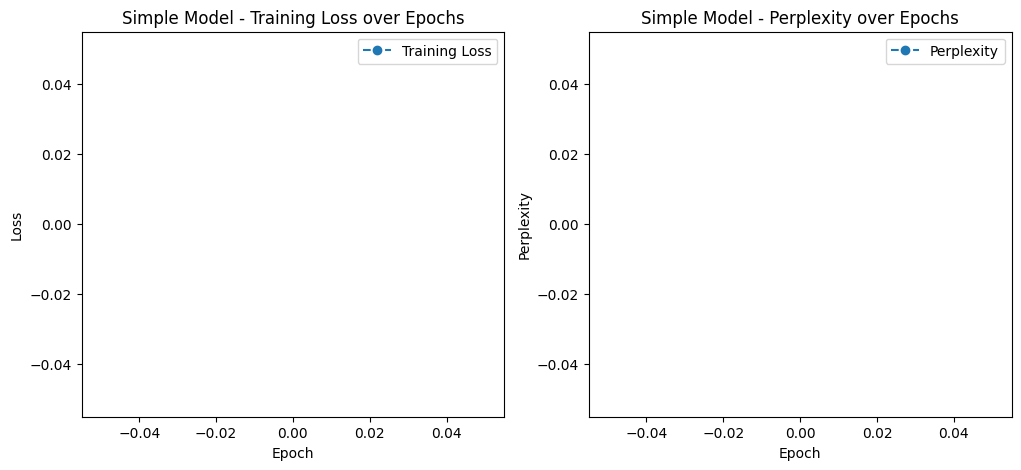

In [19]:
# Plotting the Loss and Perplexity

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', linestyle='dashed', marker="o")
plt.title('Simple Model - Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(perplexities, label='Perplexity', linestyle='dashed', marker="o")
plt.title('Simple Model - Perplexity over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.legend()

plt.show()

In [20]:
model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_simple = math.exp(avg_loss)
print(f"Perplexity of base model: {perplexity_simple:.2f}")

Perplexity of base model: 6.25


In [56]:
def generate_text(model, tokenizer, start_text, context_length=15, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat([context, next_token_id.unsqueeze(0)], dim=1)
    
    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=20)
print("Generated Text:\n")
print(generated_text)

TypeError: tuple indices must be integers or slices, not tuple

In [26]:
import torch
import torch.nn as nn

class ConvolutionalLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_length, num_heads=4, num_layers=2, dropout=0.2):
        super(ConvolutionalLanguageModel, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(context_length, embedding_dim)
        
        # Convolutional block
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=embedding_dim, kernel_size=5, padding=2)
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        self.relu = nn.ReLU()

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, 
            nhead=num_heads, 
            dim_feedforward=embedding_dim * 4,
            dropout=dropout,
            batch_first=True,
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        positions = torch.arange(0, x.size(1), device=x.device).unsqueeze(0)
        token_embeds = self.token_embedding(x)
        position_embeds = self.position_embedding(positions)
        
        embeddings = token_embeds + position_embeds
        embeddings = self.dropout(embeddings)

        # Convolutional processing
        embeddings = embeddings.transpose(1, 2)  # Convert to [batch_size, embedding_dim, seq_len]
        embeddings = self.conv1(embeddings)
        embeddings = self.relu(self.batch_norm(embeddings))
        embeddings = self.conv2(embeddings)
        embeddings = embeddings.transpose(1, 2)  # Convert back to [batch_size, seq_len, embedding_dim]

        # Transformer processing
        embeddings = self.layer_norm(embeddings)
        transformer_output = self.transformer(embeddings)
        logits = self.linear(transformer_output)
        return logits

In [57]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Parameters
batch_size = 128
context_length = 32  # Context size for training
# vocab_size = tokenizer.n_vocab
vocab_size = 30000
embedding_dim = 128

# Create the DataLoader
# train_dataloader, dev_dataloader, test_dataloader = create_dataloader(
#     formatted_text[:9999297], batch_size=batch_size, 
#     context_length=context_length, shuffle=True
# )

# Initialize the model
model = ConvolutionalLanguageModel(vocab_size, embedding_dim, context_length).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop parameters
num_epochs = 2

Using device: cuda


In [58]:
import matplotlib.pyplot as plt

num_epochs = 1
train_losses = []
perplexities = []

# Go through learning epochs
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    
    # Read in data in batches
    for batch_idx, (x, y) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)

        # Reset the gradients
        optimizer.zero_grad()

        # Apply the forward pass
        logits = model(x)

        # Reshape logits and labels
        token_logits = logits.view(-1, vocab_size)
        token_labels = y.view(-1)

        # To understand what is happening during reshaping, print out logits.shape and token_logits.shape
        # and the same for y
        # print(logits.shape, token_logits.shape)
        # print(y.shape, token_labels.shape)
        # print(y[0])
        # print(token_labels[0:10])

        # Calculate the loss
        loss = criterion(token_logits,token_labels)

        # Apply the backward step (calculate the gradients) 
        loss.backward()

        # Adjust the weights
        optimizer.step()

        # Accumulate the loss over batches
        total_loss += loss.item()

        # Monitor progress every twenty batches
        if batch_idx % 20 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}, Token Logits: {token_logits.shape}, Token Labels: {token_labels.shape}, y: {y.shape}, logits: {logits.shape}")

    # Calculate average cross-entropy loss and perplexity
    avg_loss = total_loss / len(train_dataloader)
    perplexity = math.exp(avg_loss)
    
    # Monitor developments over learning process
    train_losses.append(avg_loss)
    perplexities.append(perplexity)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {avg_loss:.4f}, Perplexity: {perplexity:.2f}")

Epoch [1/1], Step [0/43387], Loss: 10.2914, Token Logits: torch.Size([4096, 30000]), Token Labels: torch.Size([4096]), y: torch.Size([128, 32]), logits: torch.Size([128, 32, 30000])
Epoch [1/1], Step [20/43387], Loss: 3.5169, Token Logits: torch.Size([4096, 30000]), Token Labels: torch.Size([4096]), y: torch.Size([128, 32]), logits: torch.Size([128, 32, 30000])
Epoch [1/1], Step [40/43387], Loss: 2.0791, Token Logits: torch.Size([4096, 30000]), Token Labels: torch.Size([4096]), y: torch.Size([128, 32]), logits: torch.Size([128, 32, 30000])
Epoch [1/1], Step [60/43387], Loss: 1.8317, Token Logits: torch.Size([4096, 30000]), Token Labels: torch.Size([4096]), y: torch.Size([128, 32]), logits: torch.Size([128, 32, 30000])
Epoch [1/1], Step [80/43387], Loss: 1.6235, Token Logits: torch.Size([4096, 30000]), Token Labels: torch.Size([4096]), y: torch.Size([128, 32]), logits: torch.Size([128, 32, 30000])
Epoch [1/1], Step [100/43387], Loss: 1.3843, Token Logits: torch.Size([4096, 30000]), Toke

KeyboardInterrupt: 

In [59]:
model.eval()
total_loss = 0

with torch.no_grad():
    for x, y in dev_dataloader:
        x = x.to(device)
        y = y.to(device)
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        total_loss += loss.item()

avg_loss = total_loss / len(dev_dataloader)
perplexity_simple = math.exp(avg_loss)
print(f"Perplexity of base model: {perplexity_simple:.2f}")

Perplexity of base model: 1.06


In [63]:
def generate_text(model, tokenizer, start_text, context_length=15, temperature=1.0):
    model.eval()
    generated = tokenizer.encode(start_text)
    context = torch.tensor(generated, dtype=torch.long, device=device).unsqueeze(0)
    
    with torch.no_grad():
        for _ in range(context_length):
            if context.size(1) >= context_length:
                break
            logits = model(context)
            next_token_logits = logits[0, -1, :] / temperature
            probabilities = torch.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probabilities, num_samples=1)
            context = torch.cat([context, next_token_id.unsqueeze(0)], dim=1)
            print(f"next_token_logits: {next_token_logits}, probabilities: {probabilities}, next_token_id: {next_token_id}, context: {context}")

    
    generated_text = tokenizer.decode(context[0].tolist())
    return generated_text

start_text = " من در راه"
generated_text = generate_text(model, tokenizer, start_text, context_length=20)
print("Generated Text:\n")
print(generated_text)

next_token_logits: tensor([ 4.3275, -5.4783, -7.5729,  ..., -6.8719, -5.1250, -6.9073],
       device='cuda:0'), probabilities: tensor([1.2609e-03, 6.9508e-08, 8.5581e-09,  ..., 1.7252e-08, 9.8970e-08,
        1.6651e-08], device='cuda:0'), next_token_id: tensor([24943], device='cuda:0'), context: tensor([[    5,    78,    46,   167,     3, 24943]], device='cuda:0')
next_token_logits: tensor([ 3.1330, -5.4079, -6.6491,  ..., -7.7862, -4.7720, -6.5186],
       device='cuda:0'), probabilities: tensor([1.6268e-04, 3.1775e-08, 9.1840e-09,  ..., 2.9458e-09, 6.0012e-08,
        1.0464e-08], device='cuda:0'), next_token_id: tensor([43], device='cuda:0'), context: tensor([[    5,    78,    46,   167,     3, 24943,    43]], device='cuda:0')
next_token_logits: tensor([ 0.1055, -4.6321, -5.2862,  ..., -5.6402, -2.8663, -4.8546],
       device='cuda:0'), probabilities: tensor([2.8401e-07, 2.4878e-09, 1.2935e-09,  ..., 9.0783e-10, 1.4545e-08,
        1.9915e-09], device='cuda:0'), next_token_id: te

In [74]:
tokenizer.decode(503)

'دنبال'

# from transformers import pipeline, AutoTokenizer, GPT2LMHeadModel
tokenizer = AutoTokenizer.from_pretrained('bolbolzaban/gpt2-persian')
model = GPT2LMHeadModel.from_pretrained('bolbolzaban/gpt2-persian')
generator = pipeline('text-generation', model, tokenizer=tokenizer, config={'max_length':512}, device='cuda')
sample = generator('در یک اتفاق شگفت انگیز، پژوهشگران')

In [50]:
# generator('رئیس دانشگاه اعلام کرد')

[{'generated_text': 'رئیس دانشگاه اعلام کرد به گزارش خبرنگار گروه استان\u200cهای باشگاه خبرنگاران جوان از یزد ؛ اوقات شرعی امروز یزد به شرح زیر است :'}]